# Distracted Driver Detection

### This Project has been divided into 5 Parts :
1. Collecting Data
2. Creating my own CNN model and training and Visualizing it.
3. Saving the predictions in the given format
4. Exploring the ResNet50 Model and Visualizing it.
5. Conclusion

### Importing Libraries

In [1]:
## using openCV to load and resize the images.
import cv2 as cv
import os
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import visualkeras
import pydot_ng
import pydotplus
import graphviz
from PIL import Image
import random
warnings.filterwarnings('ignore')

#### Data Directory Path

In [2]:
data_dir = os.path.join('Data', 'imgs')
train_data_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

## Data Collection

### Essential Functions

In [3]:
def get_metadata(data_dir) :
    ## returns the metadata dataframe which has file names and there class
    return pd.read_csv(os.path.join(data_dir,'driver_imgs_list.csv'))

In [4]:
def get_train_data(train_dir) :
    ## This is the function for retriving the training dataframe, which has two columns, train img file path and its class
    train_data = list()
    ## traversing the train data folder, which has 10 subfolders of each category
    for class_folder in os.listdir(train_dir) :
        class_name = class_folder
        class_folder_path = os.path.join(train_dir, class_name)
        ## traversing each image file in the subfolder
        for image_file in os.listdir(class_folder_path) :
            ## storing the file and class
            train_data.append((os.path.join(class_folder_path, image_file), class_name))
    ## returning the dataframe
    return pd.DataFrame(train_data, columns = ['File_Names', 'Class_names'])

In [5]:
def get_test_images(test_dir, desired_width, desired_height) :
    ## This function is made for retrieving the test images
    test_images = list()
    ## Traversing each image in the test folder.
    for img_path in os.listdir(test_dir) :
        ## loading the image
        img = cv.imread(os.path.join(test_dir, img_path))
        ## resizing the image to desired size
        resized_image = cv.resize(img, (desired_width, desired_height), interpolation=cv.INTER_AREA)
        ## converting from RGB to Grayscale
        gray_frame = cv.cvtColor(resized_image, cv.COLOR_BGR2GRAY)
        ## storing the Grayscale Image
        test_images.append(gray_frame)
    ## Returning The Images and thier names.
    return np.array(test_images) , os.listdir(test_dir)

In [6]:
def get_resized_train_images(images_df, desired_width, desired_height) :
    ## This function is made for loading and resizing the training images from the metadata.
    images_list = list(images_df['File_Names'])
    ## traversing each file name
    itr = 0
    ## travering each path
    for image_path in images_list :
        ## loading the image
        img = cv.imread(image_path)
        ## resizing the image to desired size
        resized_image = cv.resize(img, (desired_width, desired_height), interpolation=cv.INTER_AREA)
        ## converting from RGB to Grayscale
        gray_frame = cv.cvtColor(resized_image, cv.COLOR_BGR2GRAY)
        ## storing the images
        images_list[itr] = gray_frame
        itr += 1
    ## returning images and class -> that is x_train and y_train
    return np.array(images_list), np.array(list(images_df['Class_names']))

In [7]:
def change_target_lables(y_train) :
    ## This function is made to change the string lable to numeric one.
    y_train_numerical = list()
    for y in y_train :
        y_train_numerical.append(int(y[-1]))
    
    return y_train_numerical

In [8]:
def get_y_train_categorical(y_train_numerical) :
    ## This function is made for converting y_train into different encoding , that is categorical
    return keras.utils.to_categorical(y_train_numerical, num_classes = len(set(y_train_numerical)), dtype= int)

In [9]:
def one_hot(y_pred_categorical) :
    ## This function is made to change the categorical back to normal.
    y_pred_numerical = list()
    for i in range(len(y_pred_categorical)) :
        y_pred_numerical.append(np.argmax(y_pred_categorical[i]))
    return np.array(y_pred_numerical)

### Main

In [10]:
DESIRED_WIDTH = 50
DESIRED_HEIGHT = 50

In [11]:
## getting training metadata
train_data_df = get_train_data(train_data_dir)
## Getting x_train and y_train.
x_train, y_train = get_resized_train_images(train_data_df, DESIRED_WIDTH, DESIRED_HEIGHT)
## Getting x_Test
x_test, x_test_file_path = get_test_images(test_dir, DESIRED_WIDTH ,DESIRED_HEIGHT)
## Converting y_train to numerical format
y_train_numerical = change_target_lables(y_train)
## Converting y_train to categorical format
y_train_categorical = get_y_train_categorical(y_train_numerical)

#### Data Shape

In [12]:
x_train.shape, x_test.shape, y_train.shape

((22424, 50, 50), (79726, 50, 50), (22424,))

### Plotting the Images

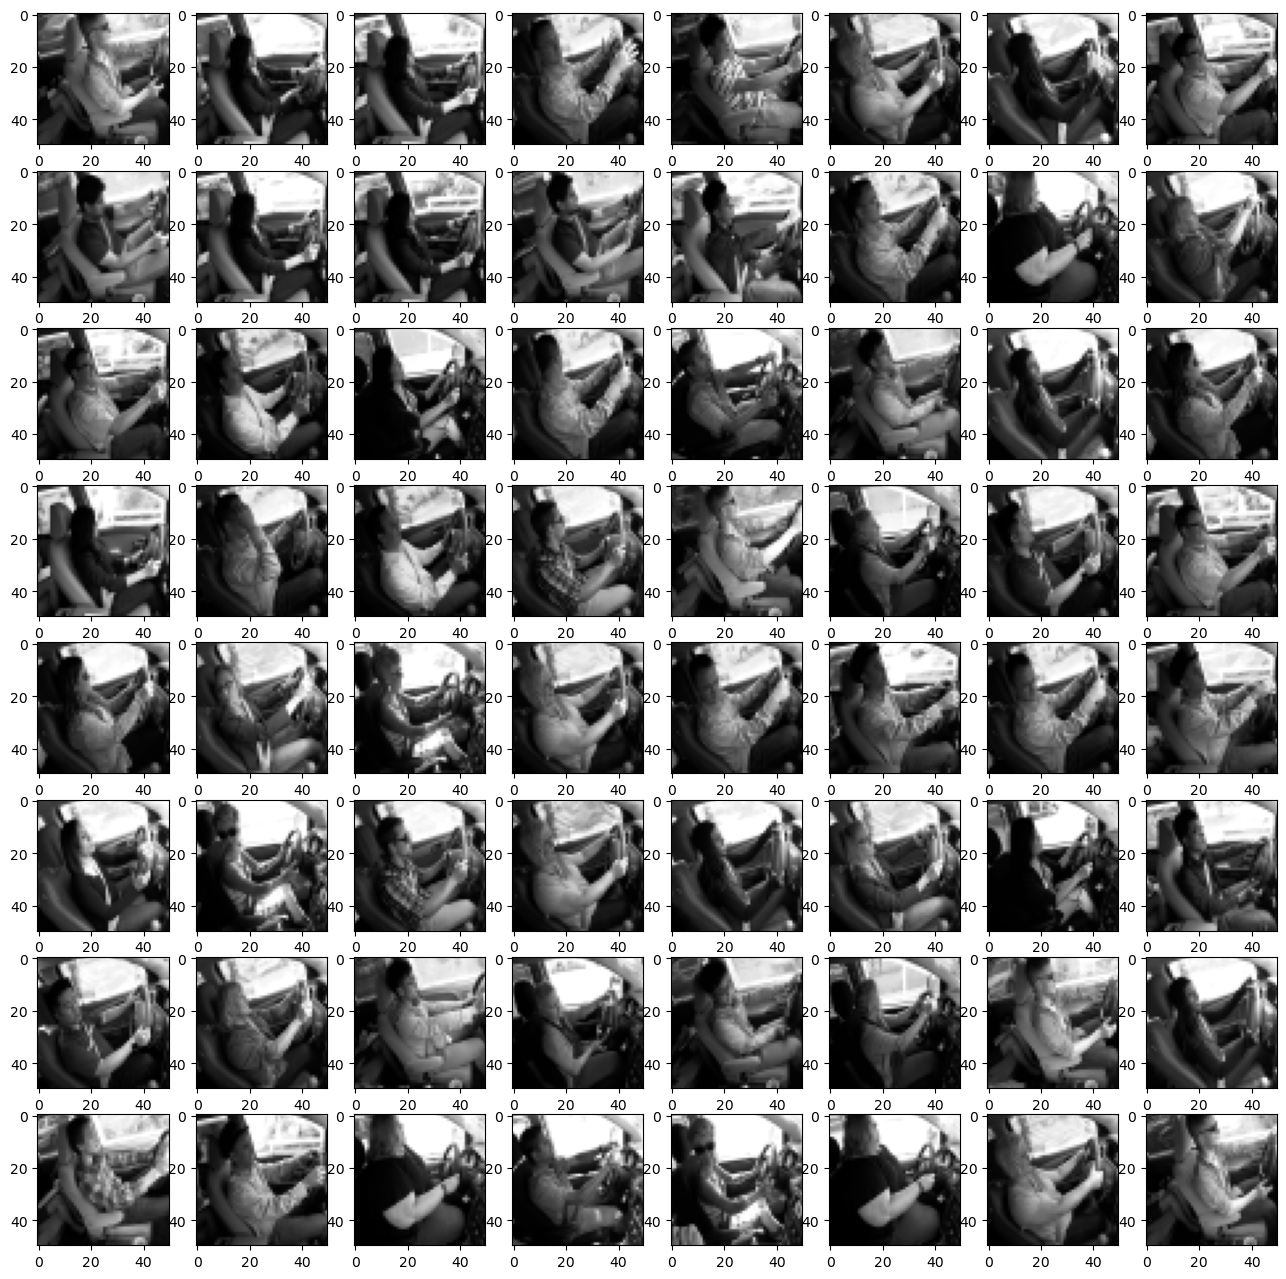

In [13]:
fig = plt.figure(figsize = (16, 16))
for i in range(64) :
    ax = fig.add_subplot(8, 8, i + 1)
    ax.imshow(x_train[i], cmap = 'gray')
plt.show()

### Defining Model

In [14]:
## this is the class of the model which I am creating.
class Distracted_Driver_Classifier :
    ## constructor
    def __init__(self, input_shape) :
        ## defining model archetecture
        self.model = Sequential()

        # 1 - Convolution
        self.model.add(Conv2D(32,(2,2), padding='same', input_shape = input_shape, activation = "relu"))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(3, 3)))

        # 2nd Convolution layer
        self.model.add(Conv2D(64,(4,4), padding='same', activation = "relu"))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(3, 3)))
        
        # 3rd Convolution layer
        self.model.add(Conv2D(64,(4,4), padding='same', activation = 'relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(3, 3)))
        self.model.add(Dropout(0.25))

        # Flattening
        self.model.add(Flatten())

        # Fully connected layer 1st layer
        self.model.add(Dense(128, activation = "relu"))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))
                       
        self.model.add(Dense(10, activation='softmax'))
        self.model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
        
    def fit(self,x_train,y_train_cateorical, epochs) :
        ## Training the model by this function.
        self.model.fit(x_train, y_train_categorical, epochs = epochs)
    
    def predict(self, x_test) :
        ## Predicting the test data.
        y_test_categorical = self.model.predict(x_test)
        return y_test_categorical
    
    def model_summary(self) :
        ## returns model summary
        return self.model.summary()
    
    def visualize_model(self) :
        ## This method actually visualize our model.
        return keras.utils.plot_model(
            self.model,
            to_file="Clf.png",
            show_shapes=True,
            show_dtype=True,
            show_layer_names=True,
            rankdir="TB",
            expand_nested=True,
            dpi=96,
            layer_range=None,
            show_layer_activations=True,
            show_trainable=False,
        )

#### Creating Classifier

In [15]:
input_shape = (DESIRED_WIDTH, DESIRED_HEIGHT, 1)
clf = Distracted_Driver_Classifier(input_shape = input_shape)

#### Model Summary

In [16]:
summary = clf.model_summary()
print(summary)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        160       
                                                                 
 batch_normalization (Batch  (None, 50, 50, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        32832     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 64)        256       
 chNormalization)                                                
                                                        

#### Visualizing the Model

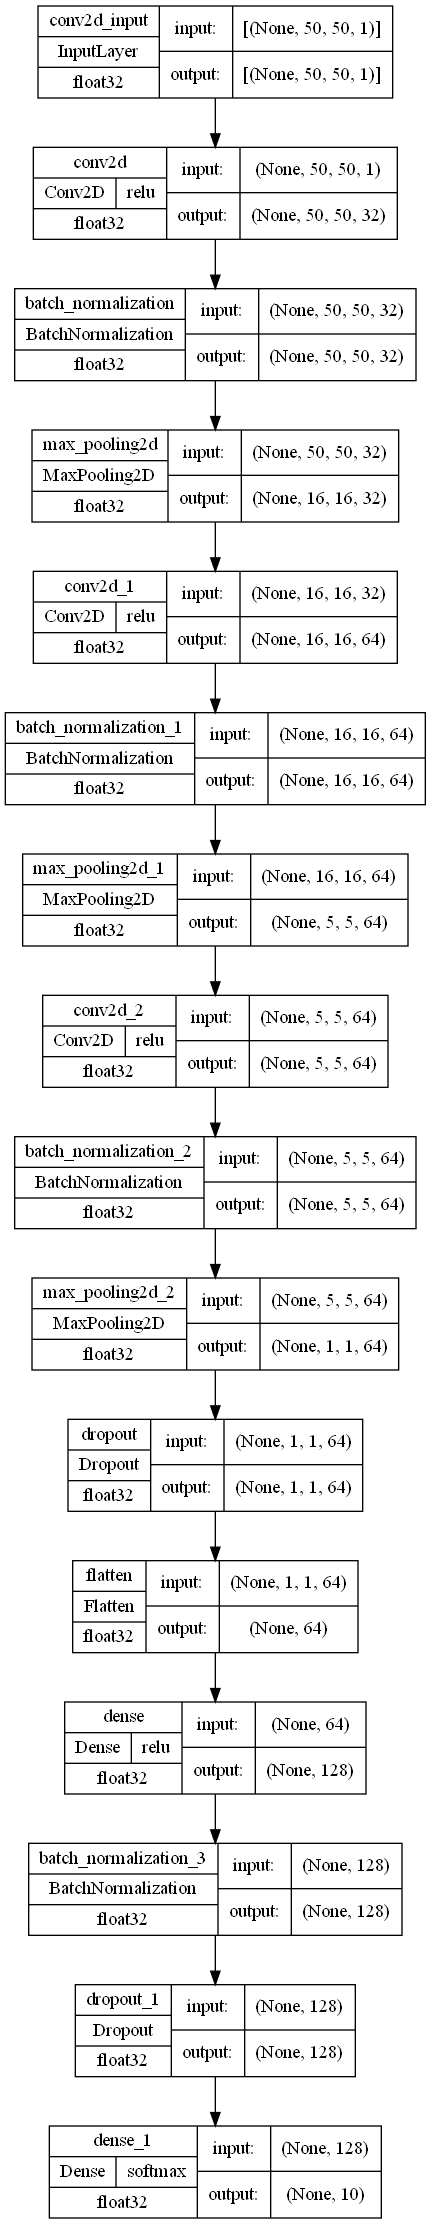

In [17]:
clf.visualize_model()

#### Training

In [18]:
clf.fit(x_train, y_train_categorical, epochs = 10)

Epoch 1/10
701/701 [==============================] - 44s 60ms/step - loss: 1.5028 - accuracy: 0.4837
Epoch 2/10
701/701 [==============================] - 42s 61ms/step - loss: 0.3599 - accuracy: 0.8870
Epoch 3/10
701/701 [==============================] - 45s 64ms/step - loss: 0.1737 - accuracy: 0.9464
Epoch 4/10
701/701 [==============================] - 47s 67ms/step - loss: 0.1207 - accuracy: 0.9604
Epoch 5/10
701/701 [==============================] - 39s 55ms/step - loss: 0.0974 - accuracy: 0.9707
Epoch 6/10
701/701 [==============================] - 40s 57ms/step - loss: 0.0732 - accuracy: 0.9762
Epoch 7/10
701/701 [==============================] - 38s 54ms/step - loss: 0.0663 - accuracy: 0.9793
Epoch 8/10
701/701 [==============================] - 38s 54ms/step - loss: 0.0585 - accuracy: 0.9812
Epoch 9/10
701/701 [==============================] - 38s 54ms/step - loss: 0.0493 - accuracy: 0.9842
Epoch 10/10
701/701 [==============================] - 38s 55ms/step - loss: 0.049

#### Testing

In [19]:
y_pred_categorical = clf.predict(x_test)

2492/2492 [==============================] - 34s 14ms/step


#### Looking at the predictions

In [20]:
y_class = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
Predicted = pd.DataFrame()
Predicted['img'] = x_test_file_path
y_pred_df = pd.DataFrame(y_pred_categorical, columns = y_class)
frames = [Predicted, y_pred_df]
Predicted = pd.concat(frames, axis=1)
Predicted

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,9.480264e-04,5.465678e-06,4.252740e-05,0.036007,5.476990e-04,6.556190e-01,4.825348e-06,5.789986e-02,0.004198,0.244728
1,img_10.jpg,4.119561e-05,1.402449e-06,1.548744e-07,0.000056,9.866086e-07,9.996734e-01,7.497438e-05,3.199015e-06,0.000021,0.000128
2,img_100.jpg,2.511250e-02,1.852029e-04,4.449277e-08,0.029534,2.355210e-05,1.260434e-05,1.702020e-08,3.799469e-05,0.000314,0.944780
3,img_1000.jpg,4.706904e-04,8.645588e-06,4.350020e-06,0.000139,1.059416e-05,7.963391e-06,2.552106e-05,5.880567e-02,0.932071,0.008456
4,img_100000.jpg,6.249017e-02,5.123233e-05,1.663886e-05,0.015254,1.503071e-03,5.693882e-04,3.328601e-05,6.489474e-03,0.648751,0.264842
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_99994.jpg,6.354377e-06,2.780916e-04,1.225414e-04,0.000022,3.880621e-06,1.786453e-03,1.423771e-05,9.852883e-01,0.000148,0.012331
79722,img_99995.jpg,4.577100e-04,3.491261e-05,6.780685e-06,0.963862,3.540592e-02,7.108325e-06,1.403270e-06,3.543232e-07,0.000003,0.000221
79723,img_99996.jpg,1.407862e-07,9.296758e-07,4.780881e-07,0.008321,9.784917e-01,1.562065e-09,3.283141e-06,1.488300e-05,0.012985,0.000182
79724,img_99998.jpg,5.656860e-06,1.126489e-05,1.531193e-01,0.000028,2.906853e-03,1.192747e-02,2.789845e-01,9.786302e-02,0.454803,0.000351


#### Saving the Categorical Predictions

In [21]:
Predicted.to_csv('Predictions(Categorical).csv', index = False)

#### Converting the prediction in different encoding

In [22]:
y_pred_numerical = one_hot(y_pred_categorical)
y_pred_numerical

array([5, 5, 9, ..., 4, 8, 5], dtype=int64)

#### Saving these predictions, only 1-D array

In [23]:
np.savetxt('Predictions(Numericals).csv', y_pred_numerical)

## Transfer Learning Model Exploration

### Using ResNet50

In [27]:
## Importing ResNet50
from tensorflow.keras.applications import ResNet50
from keras.layers import Input, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

## Freezing the middle layers and making them non-trainable.
for layer in base_model.layers:
    layer.trainable = False
    
## Extracting the model layers as I need to pass my own input and output layer
x = base_model.layers[-1].output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
custom_output = Dense(10, activation='softmax')(x)

## Converting from Grayscale to RGB as ResNet50 works on RGB images.
input_tensor = Input(shape=(224, 224, 1))
gray_to_rgb = Concatenate()([input_tensor, input_tensor, input_tensor])  # Duplicate the grayscale channel 3 times
output = base_model(gray_to_rgb)
## Integrating the model with my layers and compiling it
model = Model(inputs=base_model.input, outputs=custom_output)
model.compile(optimizer= "adam", loss='categorical_crossentropy', metrics=['accuracy'])

#### Model Summary 

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 50, 50, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 56, 56, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 25, 25, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 25, 25, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 13, 13, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 13, 13, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 13, 13, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 7, 7, 512)            66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 7, 7, 512)            0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 4, 4, 256)            590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 4, 4, 256)            1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 4, 4, 256)            0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 4, 4, 1024)           525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 4, 4, 1024)           0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 4, 4, 256)            262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 4, 4, 256)            1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 4, 4, 1024)           4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 4, 4, 1024)           0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 4, 4, 1024)           0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 2, 2, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 2, 2, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 2, 2, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 2, 2, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

#### Visualizing ResNet50


(process:16956): GLib-GIO-WARNING **: 03:34:53.267: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2309.16.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:16956): GLib-GIO-WARNING **: 03:34:53.432: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.8.1.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs



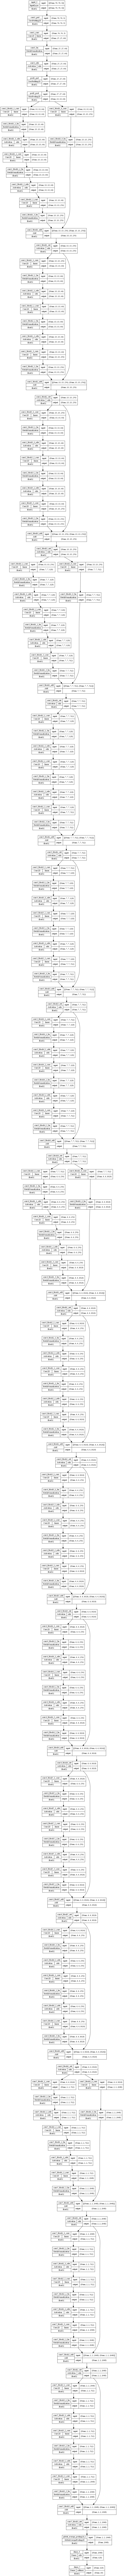

In [29]:
keras.utils.plot_model(
            model,
            to_file="Clf2.png",
            show_shapes=True,
            show_dtype=True,
            show_layer_names=True,
            rankdir="TB",
            expand_nested=True,
            dpi=96,
            layer_range=None,
            show_layer_activations=True,
            show_trainable=False,
        )

## Conclusion
- The model created by me has accuracy of 98%
- I am not training ResNet50 as it will take a lot of space, so I have just explored it and visualized it.

### Submitted By - Prateek Sarna